# Notebook

### Import packages

In [1]:
import sys
sys.path.insert(0, './modules')

from functions import *
from gmcs import *

# additional (for plotting)
import matplotlib.pyplot as plt

## Input data and parameters

In [30]:
# INPUT DATA

# galaxy data
Mmol_tot = 3.33e+10 # Msun
r25 = 13.76 # kpc
logLX = 43.19 # erg/s (2-10 keV)
FUVparams = 1.10, 1.35, 0.70

# GMCs data
gmcs = e23list

# script parameters
outfolder = './ngc7469/'
logR_step = 0.05
a = 1.64 # GMC mass PL distribution index

# additional data
G0floor = True
Jmax = 13

### Fill the galaxy with GMCs ...

In [33]:
quanta = gmc_fill(outfolder, Mmol_tot, r25, logR_step, gmcs, a, verbose=True)

### ... or import a file if you already did it

In [ ]:
quanta = pd.read_csv(outfolder + 'GMCs_Nradii74_a164.csv', index_col=0)

## Generate the baseline CO SLED

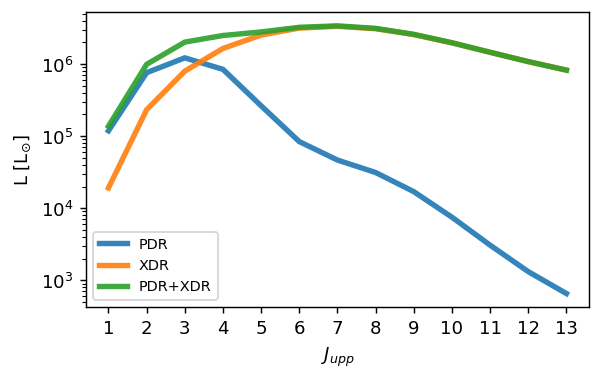

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=130)
kwargs = {'lw': 3, 'alpha': 0.9}
Jupp = np.arange(1,14)

# baseline SLED
blSLED = baseline_sled(quanta, gmcs, logLX, FUVparams, G0floor=G0floor, Jmax=Jmax)
ax.plot(Jupp, blSLED[0], label='PDR', **kwargs)
ax.plot(Jupp, blSLED[1], label='XDR', **kwargs)
ax.plot(Jupp, blSLED[2], label='PDR+XDR', **kwargs)

ax.set_yscale('log')
ax.legend(fontsize=8)
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel('L [L$_{\odot}$]');

## Fit the baseline model to a observed CO SLED

#### Input observed CO SLED, lower errors, upper errors, and upper limits

In [46]:
# ONLY ACCEPTED UNITS ARE SOLAR LUMINOSITIES
# all arrays must have the same length (13)
# `ulim` array has to contain 1 in case of non-detections, 0 in case of detections
# in case of upper limit, the first array has the corresponding 3sigma upper limit
# in case of upper limit, `lo` and `hi` values are only for plotting purposes

coSLED = 10**np.array([5.24, 6.02, 6.44, 6.69, 6.83, 6.80, 
                       6.71, 6.62, 6.58, 6.40, 6.35, 6.20, 6.15])
coSLED_lo = np.array([0.15, 0.12, 0.15, 0.06, 0.06, 0.06, 
                      0.06, 0.07, 0.07, 0.07, 0.09, 0.10, 0.19]) * coSLED
coSLED_up = np.array([0.15, 0.12, 0.15, 0.06, 0.06, 0.06, 
                      0.06, 0.06, 0.07, 0.07, 0.09, 0.10, 0.20]) * coSLED
coSLED_ulim = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Plot the observed CO SLED

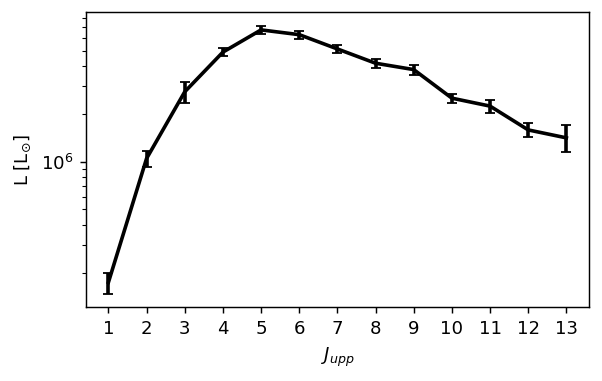

In [47]:
obSLED = [coSLED, coSLED_lo, coSLED_up, coSLED_ulim]
#obSLED = [dfSLED, dfSLED_lo, dfSLED_up, dfSLED_ulim]

fig, ax = plt.subplots(1, 1, figsize=(5,3), dpi=130)
Jupp = np.arange(1, 14)

ax.errorbar(Jupp, obSLED[0], color='k', capsize=3, lw=2,
            yerr = [obSLED[1], obSLED[2]], uplims = obSLED[3])
ax.set_yscale('log')
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel('L [L$_{\odot}$]');

#### Fit the observed CO SLED and plot all models

In [48]:
bestfit_params = COfit(obSLED, quanta, gmcs, logLX, FUVparams, G0floor, Jmax=Jmax, chi_thresh=0.15)

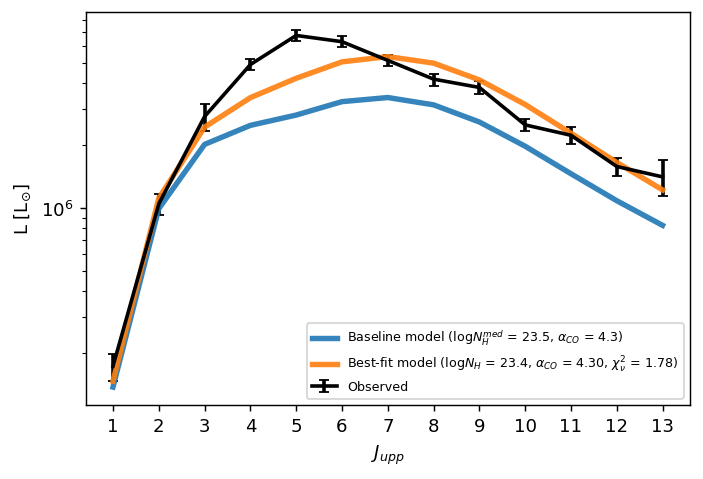

In [49]:
logNH, alphaCO, red_chi = bestfit_params

fig, ax = plt.subplots(1, 1, figsize=(6,4), dpi=130)
Jupp = np.arange(1, 14)
kwargs = {'lw': 3, 'alpha': 0.9}

# observed SLED
ax.errorbar(Jupp, obSLED[0], color='k', capsize=3, lw=2,
            yerr = [obSLED[1], obSLED[2]], uplims = obSLED[3],
            label = 'Observed')

# baseline SLED
blSLED = baseline_sled(quanta, gmcs, logLX, FUVparams, G0floor=G0floor, Jmax=Jmax)
baselab = r'Baseline model (log$N_H^{med}$ = %.1f, $\alpha_{CO}$ = 4.3)' % np.log10(quanta.NH_r.median())
ax.plot(Jupp, blSLED[2], label=baselab, **kwargs)

# best-fit SLED
fitSLED = baseline_sled(quanta, gmcs, logLX, FUVparams, flatNH=logNH, G0floor=G0floor, Jmax=Jmax)
fitlab = r'Best-fit model (log$N_H$ = %.1f, $\alpha_{CO}$ = %.2f, $\chi^2_{\nu}$ = %.2f)' % bestfit_params
ax.plot(Jupp, fitSLED[2]*alphaCO/4.3, label=fitlab, **kwargs)

ax.set_yscale('log')
ax.legend(fontsize=7)
ax.set_xticks(Jupp)
ax.set_xlabel(r'$J_{upp}$')
ax.set_ylabel('L [L$_{\odot}$]');

***

## APPENDIX: check the slope of the GMC fill-up procedure

In [38]:
def slope_check(quanta, gmcs, a):
    '''
    Plot the slope of the generated GMC mass power-law distribution
    It is useful to check it against the predicted a value (plotted with a dashed line)
    It can only calculate the slope for rings where there is at least 1 GMC of every mass
    '''
    gmcCounts = [quanta.loc[i, quanta.columns[3:-4]].to_numpy() for i in quanta.index]
    gmcMasses = np.array([gmc.M for gmc in gmcs])
    slopes = []
    for i in quanta.index:
        slopes.append(linregress(np.log10(gmcMasses), np.log10(gmcCounts[i]))[0])
    slope = linregress(np.log10(gmcMasses), np.log10(sum(gmcCounts)))[0]
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=130)
    ax.scatter(quanta.r, slopes, s=80, edgecolors='k')
    ax.axhline(slope, c='green', lw=2, alpha=.8)
    ax.axhline(-a, c='k', ls=(0,(5,5)), alpha=.7)
    ax.set_xscale('log')
    ax.set_xlabel('r [pc]')
    ax.set_ylabel('Slope');

<ipython-input-38-f837d5e27b3a>:11: RuntimeWarning: divide by zero encountered in log10
  slopes.append(linregress(np.log10(gmcMasses), np.log10(gmcCounts[i]))[0])
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


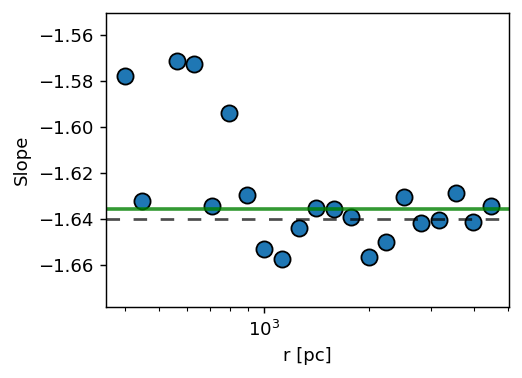

In [39]:
outfolder = './ngc7469/'
gmcs = e23list
a = 1.64
quanta = pd.read_csv(outfolder + 'GMCs_Nradii74_a164.csv', index_col=0)
slope_check(quanta, gmcs, a)